### Step 1: Set up the environment and load stream data

First, import the required libraries and instantiate the galstreams library to access the stream data. 


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from galstreams import MWStreams
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u

mws = MWStreams()

# Enable interactive plotting in a Jupyter notebook for a rotatable 3D plot
#%matplotlib notebook
%matplotlib widget


Initializing galstreams library from master_log... 


        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use name instead. [gala.dynamics.core]
        Use n

### Step 2: Select streams and globular clusters

The galstreams library is primarily for stellar streams, but you can also retrieve globular cluster information from stream data if the progenitor is known. For a comprehensive list of globular clusters, you would typically use a separate catalog. For this example, we'll demonstrate using progenitor information from galstreams. 


In [17]:
import astropy.units as u
names = ['Pal5-PW19', 'GD-1-I21']

# Select a few streams and their progenitor globular clusters
selected_streams_data = {
    'Pal_5': mws[names[0]],
    'GD_1': mws[names[1]],
}

# The galstreams library holds progenitor information. For Pal_5, the progenitor is the globular cluster Palomar 5.
# However, stream objects do not contain progenitor coordinates. We will manually define one for plotting purposes.
globular_clusters_data = {
    'Palomar_5': {
        'ra': 229.027 * u.deg, 
        'dec': -0.119 * u.deg, 
        'distance': 22.89 * u.kpc, # Example distance, you may need a more precise catalog
        'label': 'Palomar 5'
    }
}

sun_data = {
    'ra': 0*u.deg,
    'dec': 0*u.deg,
    'distance': 0.0*u.kpc
}


### Step 3: Convert to a 3D Cartesian Galactocentric frame

The galstreams stream data is stored as astropy.coordinates.SkyCoord objects. You need to transform these coordinates (and the manually defined globular cluster coordinates) into a Galactocentric Cartesian frame to plot them in 3D. astropy's Galactocentric frame handles this conversion, and you can specify parameters like the Sun's position relative to the galactic center. 


In [18]:
# Define Sun's position relative to the Galactic Center (approximate)
gc_frame = Galactocentric()

# Convert stream tracks to Galactocentric coordinates
streams_galactocentric = {}
for name, stream in selected_streams_data.items():
    streams_galactocentric[name] = stream.track.transform_to(gc_frame)

# Create SkyCoord object for globular clusters and convert to Galactocentric
gc_coords = SkyCoord(
    ra=[gc['ra'] for gc in globular_clusters_data.values()],
    dec=[gc['dec'] for gc in globular_clusters_data.values()],
    distance=[gc['distance'] for gc in globular_clusters_data.values()]
)
gc_galactocentric = gc_coords.transform_to(gc_frame)

# Extract Cartesian coordinates (x, y, z)
gc_x, gc_y, gc_z = gc_galactocentric.x.value, gc_galactocentric.y.value, gc_galactocentric.z.value

sun_coord=SkyCoord(ra=sun_data['ra'], dec=sun_data['dec'], distance=sun_data['distance'])
sun_gal = sun_coord.transform_to(gc_frame)
sun_x, sun_y, sun_z = sun_gal.x.value, sun_gal.y.value, sun_gal.z.value


### Step 4: Plot the data in an isometric 3D projection

With the Galactocentric Cartesian coordinates, you can now use matplotlib to create the 3D scatter plot. To achieve an isometric-like view, you can set the camera view angle, although matplotlib uses an orthographic projection for its 'isometric' view by default. 


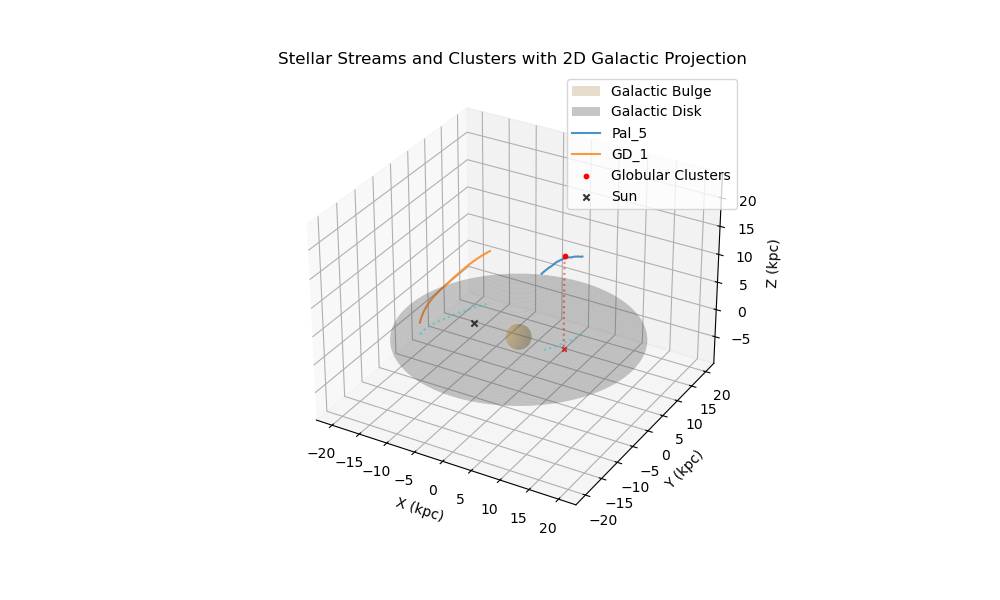

In [23]:
import astropy.units as u

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Create the Milky Way's galactic bulge (idealized as a sphere)
bulge_radius = 2 * u.kpc
u_bulge = np.linspace(0, 2 * np.pi, 50)
v_bulge = np.linspace(0, np.pi, 50)
x_bulge = bulge_radius.value * np.outer(np.cos(u_bulge), np.sin(v_bulge))
y_bulge = bulge_radius.value * np.outer(np.sin(u_bulge), np.sin(v_bulge))
z_bulge = bulge_radius.value * np.outer(np.ones(np.size(u_bulge)), np.cos(v_bulge))

ax.plot_surface(x_bulge, y_bulge, z_bulge, color='orange', alpha=0.2, label='Galactic Bulge')

# Plot the idealized Milky Way galactic disk (wireframe on z=0)
disk_radius = 20 * u.kpc
disk_height = 0.5 * u.kpc # A thin disk

#ax.plot_wireframe(x_disk, y_disk, z_disk, color='gray', alpha=0.15)

#circle = patches.Circle((0, 0), radius=20, edgecolor='blue', facecolor='lightblue', alpha=0.7)
#ax.add_patch(circle)
#art3d.pathpatch_2d_to_3d(circle, z=0, zdir='z')

R = np.linspace(0, disk_radius, 100)
h = np.linspace(-disk_height, disk_height, 10)
u = np.linspace(0,  2*np.pi, 100)

x = np.outer(R, np.cos(u))
y = np.outer(R, np.sin(u))
z = np.outer(R, 0)
ax.plot_surface(x,y,z, color='grey', alpha=0.3, label='Galactic Disk')

#ax.plot_surface(x,y,z, edgecolor='lightblue', color='lightblue', alpha=0.7)

# Plot stellar streams in 3D and their projections
for name, stream_coords in streams_galactocentric.items():
    x_stream = stream_coords.x.value
    y_stream = stream_coords.y.value
    z_stream = stream_coords.z.value
    
    # Plot stream in 3D
    ax.plot(x_stream, y_stream, z_stream, label=name, alpha=0.8, linestyle='-')
    
    # Plot 2D projection on the xy-plane (z=0)
    ax.plot(x_stream, y_stream, np.zeros_like(z_stream), color='cyan', alpha=0.5, linestyle=':', zdir='z')
    
    # Plot vertical projection lines
    #for i in range(0, len(x_stream), 20):  # Plot a subset for clarity
    #    ax.plot([x_stream[i], x_stream[i]], [y_stream[i], y_stream[i]], [z_stream[i], 0], color='gray', linestyle=':', alpha=0.3)

# Plot globular clusters in 3D and their projections
ax.scatter(gc_x, gc_y, gc_z, c='red', marker='o', s=10, label='Globular Clusters', zorder=10)
for i in range(len(gc_x)):
    # Plot 2D projection on the xy-plane
    ax.scatter(gc_x[i], gc_y[i], 0, c='red', marker='x', s=10, alpha=0.8, zorder=10)
    
    # Plot vertical projection lines
    ax.plot([gc_x[i], gc_x[i]], [gc_y[i], gc_y[i]], [gc_z[i], 0], color='red', linestyle=':', alpha=0.5)


ax.scatter(sun_x, sun_y, sun_z, c='black', marker='x', s=20, alpha=0.8, zorder=10, label="Sun")

# Set labels, title, and legend
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')
ax.set_title('Stellar Streams and Clusters with 2D Galactic Projection')
ax.legend()

# Configure plot aesthetics
#ax.set_facecolor('black')
#ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
#ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
#ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))

# Set the isometric-style view for better visualization
ax.view_init(elev=30, azim=-60)
ax.axis('equal')

plt.show()
